In [1]:
import re
import numpy as np
from plot_log import (
    get_results,
    get_task_model_dict,
    plot_task_results,
    get_ppl_model_dict,
    plot_ppl_results,
    plot_layer_loss,
    plot_task_results_violin,
)

('0', '0', '0.023954108357429504', '0.28997743129730225', '16404.5771484375')
{'arc_challenge': {'acc': 0.2440273037542662, 'acc_stderr': 0.012551447627856262, 'acc_norm': 0.28924914675767915, 'acc_norm_stderr': 0.013250012579393443}, 'arc_easy': {'acc': 0.37962962962962965, 'acc_stderr': 0.009958037725468561, 'acc_norm': 0.3404882154882155, 'acc_norm_stderr': 0.009723676813825877}, 'hellaswag': {'acc': 0.35660227046405096, 'acc_stderr': 0.004780169873332848, 'acc_norm': 0.43168691495717987, 'acc_norm_stderr': 0.004942990623131105}, 'boolq': {'acc': 0.6033639143730887, 'acc_stderr': 0.008556148582031997}, 'piqa': {'acc': 0.6011969532100109, 'acc_stderr': 0.011424390545037282, 'acc_norm': 0.5984766050054406, 'acc_norm_stderr': 0.011437324373397846}, 'winogrande': {'acc': 0.5280189423835833, 'acc_stderr': 0.01403040421340578}}
('wikitext2', '12.18686580657959')


In [2]:
import pandas as pd
from io import StringIO

prev_method_results_csv = StringIO(
    "\n".join(
        [
            "method,piqa,arc_easy,arc_challenge,boolq,hellaswag,winogrande,avg",
            "FP16,78.40,67.34,38.13,73.11,56.42,66.85,63.38",
            # "LAE,56.58,28.74,21.84,56.39,27.32,52.72,40.60",
            "SmoothQuant,61.86,42.42,22.86,58.37,33.30,50.51,44.89",
            "OmniQuant,63.49,46.17,24.74,62.53,39.58,53.51,48.34",
            "LRQuant,66.64,52.98,28.92,63.30,43.99,53.51,51.56",
        ]
    )
)
df = pd.read_csv(prev_method_results_csv)

prev_method_results = {}
for i, row in df.iterrows():
    method = row["method"]
    tasks = row.drop("method")
    for task, score in tasks.items():
        if task == "avg":
            continue
        prev_method_results.setdefault(method, {"tasks": [{}]})["tasks"][0][task] = {
            "acc": score / 100
        }

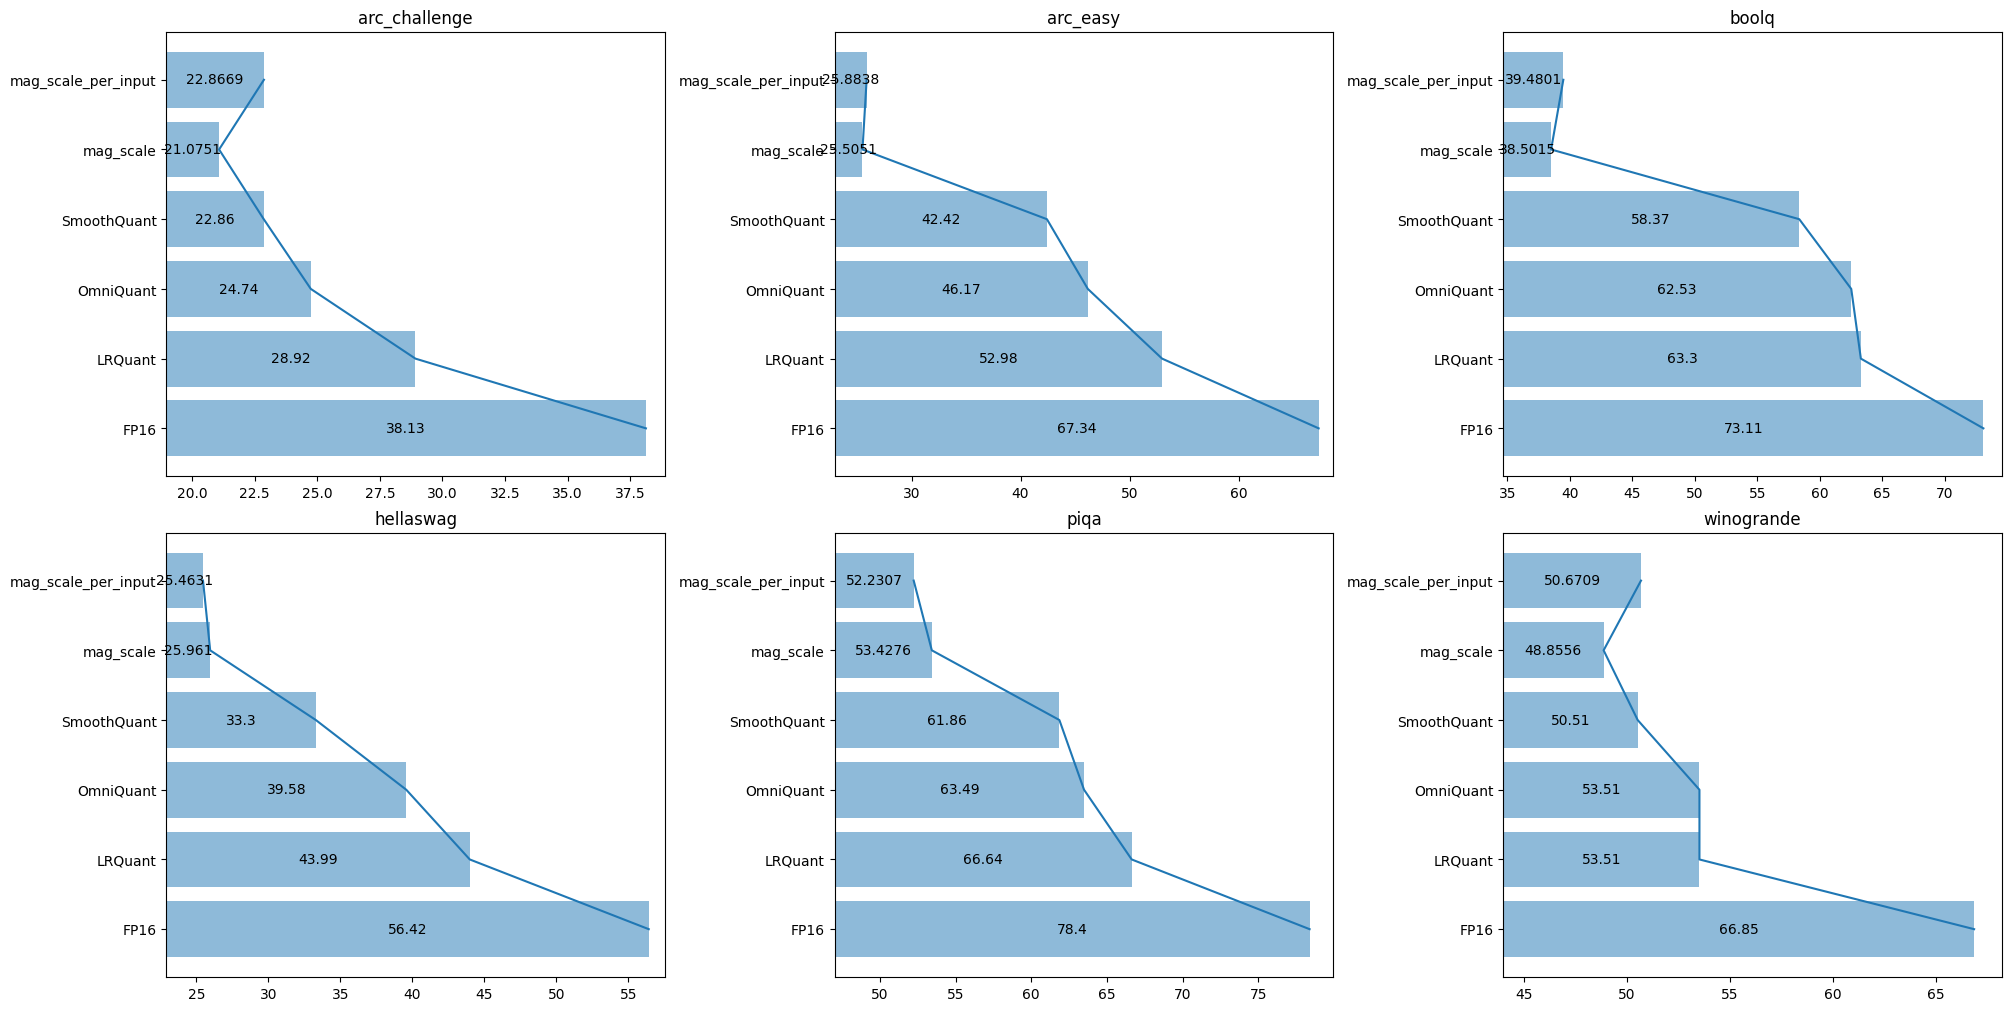

In [3]:
prev_task_dict = get_task_model_dict(prev_method_results)
suppress_outlier = get_results(log_dir_path="../log/suppress_outlier", ignore_models=["fixed_scale"])

suppress_outlier_task_model_dict = get_task_model_dict(suppress_outlier)
for task, task_results in suppress_outlier_task_model_dict.items():
    for (model, value) in task_results:
        prev_task_dict[task].append((model, value))
    
plot_task_results(prev_task_dict, padding_right=0.02)

In [ ]:
prev_task_dict = get_task_model_dict(prev_method_results)
print(prev_task_dict)

base = get_results(log_dir_path="../log/base",
    # allowd_models=[
    #     # re.compile('^sw-'),
    #     "base",
    #     re.compile('^ls\.?\d$'),
    # ],
)
softmax_both = get_results(log_dir_path="../log/softmax_both")
softmax_nlc = get_results(log_dir_path="../log/softmax_nlc")

base_task_model_dict = get_task_model_dict(base)
for task, task_results in base_task_model_dict.items():
    prev_task_dict[task].append(("base_avg", np.mean([value for _, value in task_results])))
    
softmax_both_task_model_dict = get_task_model_dict(softmax_both)
for task, task_results in softmax_both_task_model_dict.items():
    prev_task_dict[task].append(("sw_both_avg", np.mean([value for _, value in task_results])))

softmax_nlc_task_model_dict = get_task_model_dict(softmax_nlc)
for task, task_results in softmax_nlc_task_model_dict.items():
    prev_task_dict[task].append(("sw_nlc_avg", np.mean([value for _, value in task_results])))
    
print(prev_task_dict)

# task_model_dict = get_task_model_dict(softmax_both)
# plot_task_results(task_model_dict)
# ppl_model_dict = get_ppl_model_dict(softmax_both)
# plot_ppl_results(ppl_model_dict)
# plot_layer_loss(softmax_both)

FileNotFoundError: [Errno 2] No such file or directory: '../log/base'

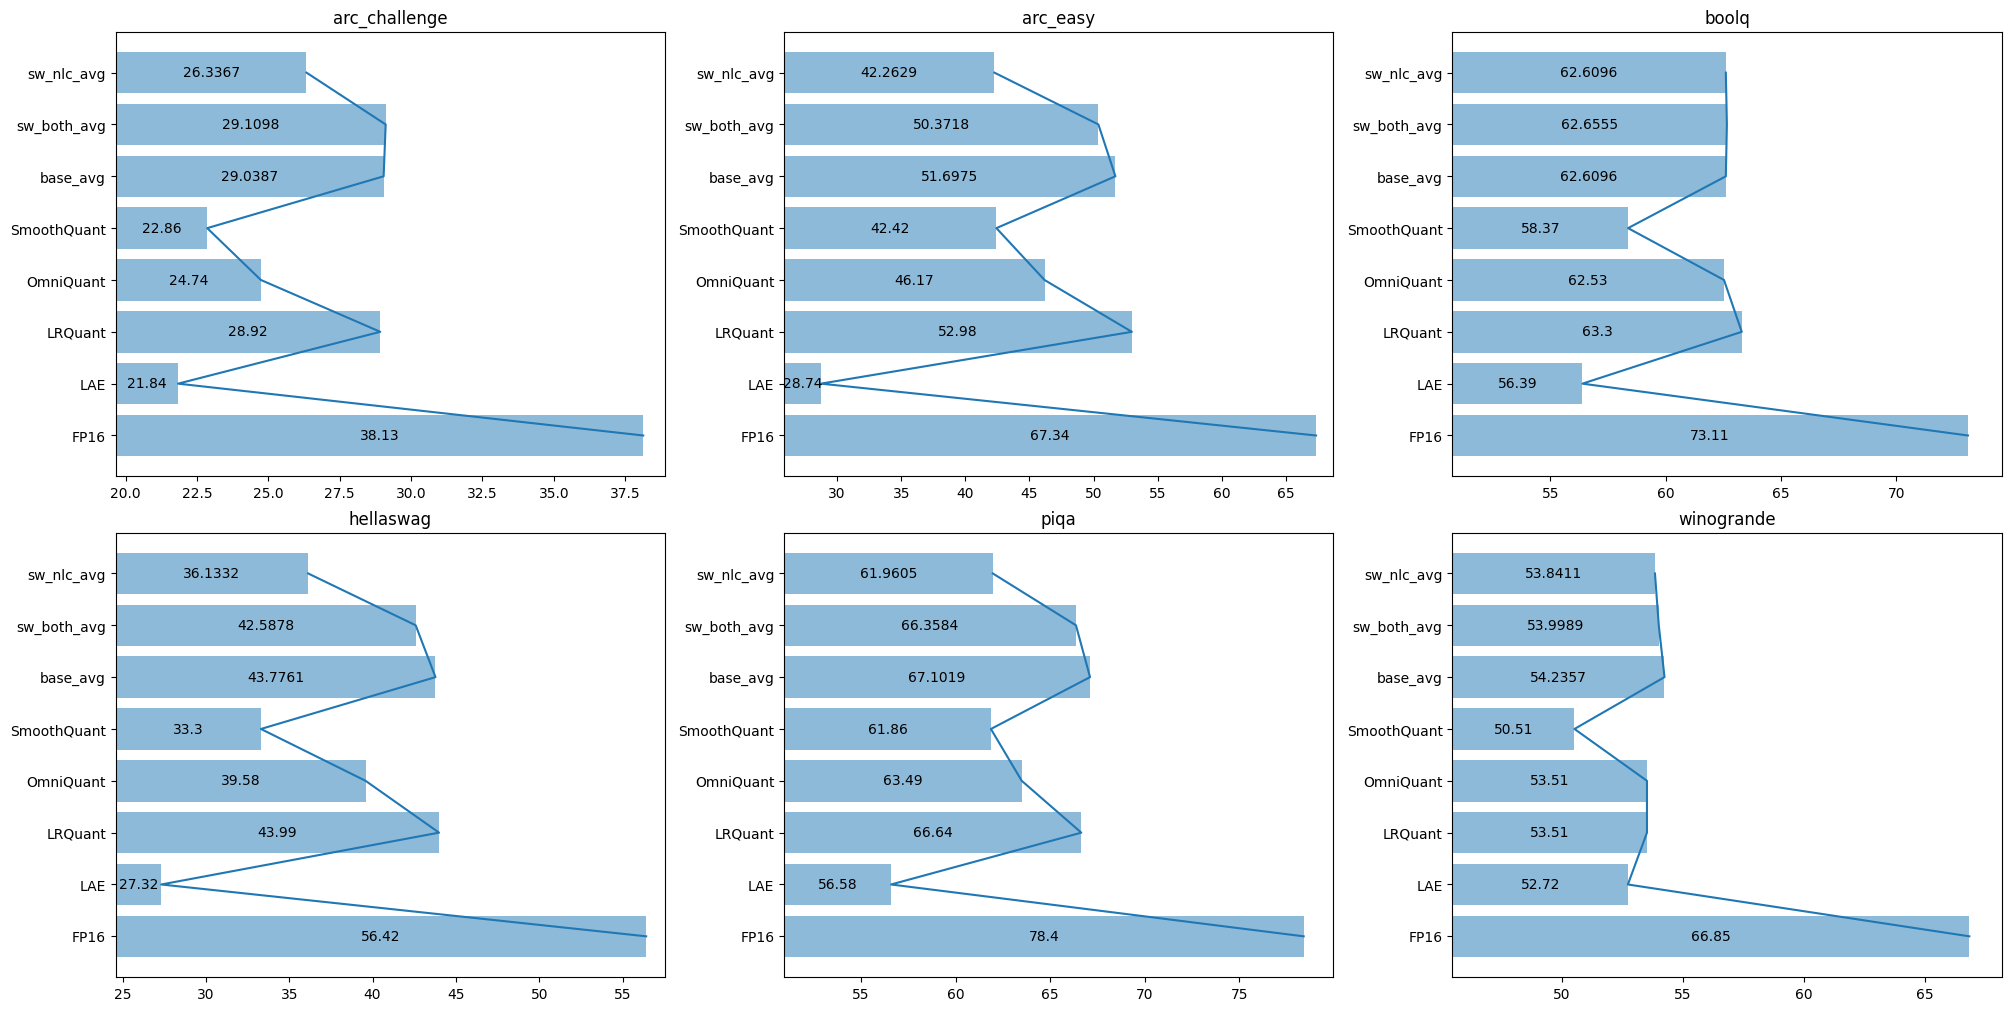

In [62]:
plot_task_results(prev_task_dict, padding_right=0.02)

In [66]:
import matplotlib.pyplot as plt


def plot_violin(task_model_dict_dict, diff_base=None):
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    task_results = {}

    for model_name, task_model_dict in task_model_dict_dict.items():
        for task, model_result in task_model_dict.items():
            if diff_base is None:
                base_result = next(
                    (value for name, value in model_result if name == diff_base), None
                )

            # model_result = [("fp16", fp_16_results[task]), *model_result]
            names, values = zip(*((name, value) for name, value in model_result))
            values = np.array(values)

            if base_result is not None:
                values_diff = (values - base_result) * 100
            else:
                values_diff = values * 100
            task_results.setdefault(task, []).append((model_name, values_diff))

    for idx, (task, task_result) in enumerate(task_results.items()):
        ax = fig.add_subplot(2, len(task_results) // 2, (idx + 1))
        ax.set_title(task)

        names, values = zip(*task_result)

        ax.boxplot(
            values,
        )
        ax.set_xticks(range(1, len(names) + 1))
        ax.set_xticklabels(names)

    plt.show()

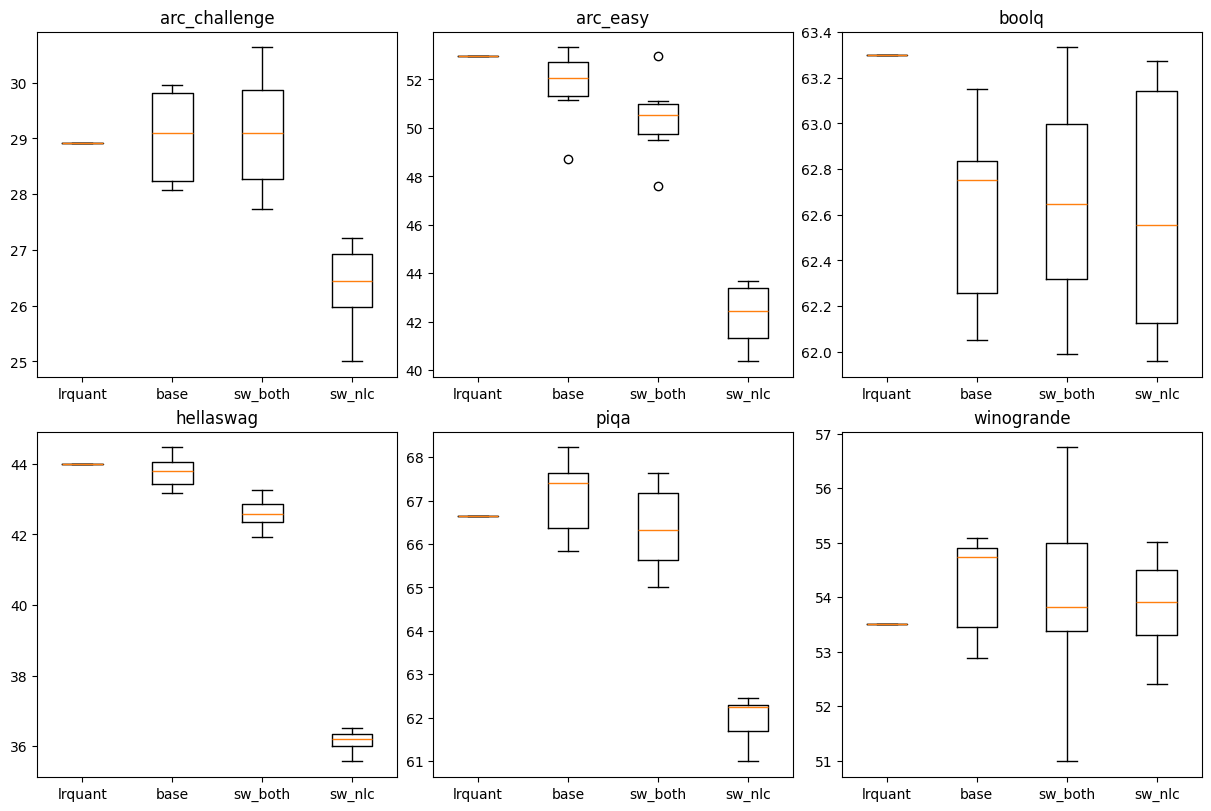

In [67]:
# plot_task_results_violin(get_task_model_dict(softmax_both))

plot_violin(
    {
        "lrquant": get_task_model_dict({"lrquant": prev_method_results['LRQuant']}),
        "base": base_task_model_dict,
        "sw_both": softmax_both_task_model_dict,
        "sw_nlc": softmax_nlc_task_model_dict,
    },
)